In [1]:
import os
import sys
sys.path.append(os.path.abspath("../src"))  # zodat Python src als modulepad herkent
from analysis import extract_pos_tag_scores
from analysis import load_file, compare_bleu_buckets, calculate_wer_per_sentence, get_knn_gain_outliers, wer_summary
from better_by import (
    load_pickle, classify_sentences,
    extract_pos, extract_entities, plot_distribution
)
import pandas as pd
import matplotlib.pyplot as plt 
from plotting import plot_wer_distribution, plot_knn_gain_scatter
from preprocessing import load_pickle, convert_pkl_to_txt

In [3]:
data_dir = "/Users/sedatgunay/Desktop/num/commonvoice"

refs = load_file("/Users/sedatgunay/Desktop/num/commonvoice/common_test_ref_texts.txt")
van = load_file("/Users/sedatgunay/Desktop/num/commonvoice/common_test_van_texts.txt")
knn = load_file("/Users/sedatgunay/Desktop/num/commonvoice/test_knn_0.1_normalized_texts.txt")

bucket_edges = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0]

df_bleu = compare_bleu_buckets(refs, knn, van, bucket_edges)

df_bleu.style.background_gradient(cmap="RdYlGn_r", subset=["Verschil (sys1 - sys2)"])

# df_bleu.to_csv("bleu_buckets_commonvoice_num.csv", index=False)  # of een andere naam per versie

,BLEU-bucket,Aantal sys1 - kNN-MT,Aantal sys2 - Vanilla,Verschil (sys1 - sys2)
0,"[0.0,10.0)",79,39,40
1,"[10.0,20.0)",346,74,272
2,"[20.0,30.0)",461,127,334
3,"[30.0,40.0)",606,204,402
4,"[40.0,50.0)",821,321,500
5,"[50.0,60.0)",1488,546,942
6,"[60.0,70.0)",1814,574,1240
7,"[70.0,80.0)",3624,1044,2580
8,"[80.0,90.0)",2060,637,1423
9,>=90.0,5,72,-67


In [4]:
html_path = "/Users/sedatgunay/Desktop/num/commonvoice/comparemt_output_commonvoice_pos/index.html"

print("POS LABEL TAGGING SCORES – COMMONVOICE- NUM Datastore")
df_commonvoice_pos = extract_pos_tag_scores(html_path)
display(df_commonvoice_pos)

POS LABEL TAGGING SCORES – COMMONVOICE- NUM Datastore


,Label,kNN-MT (sys1),Vanilla (sys2),Verschil (sys1 - sys2)
0,ADJ,0.8292,0.9374,-0.1082
1,NOUN,0.7147,0.9218,-0.2071
2,PROPN,0.0760,0.8300,-0.7540
3,VERB,0.6909,0.9375,-0.2466
4,ADV,0.7580,0.9635,-0.2055
5,NUM,0.5297,0.6730,-0.1433
6,DET,0.8083,0.9774,-0.1691
7,PRON,0.6017,0.9575,-0.3558
8,ADP,0.8842,0.9791,-0.0949
9,CCONJ,0.8270,0.9709,-0.1439


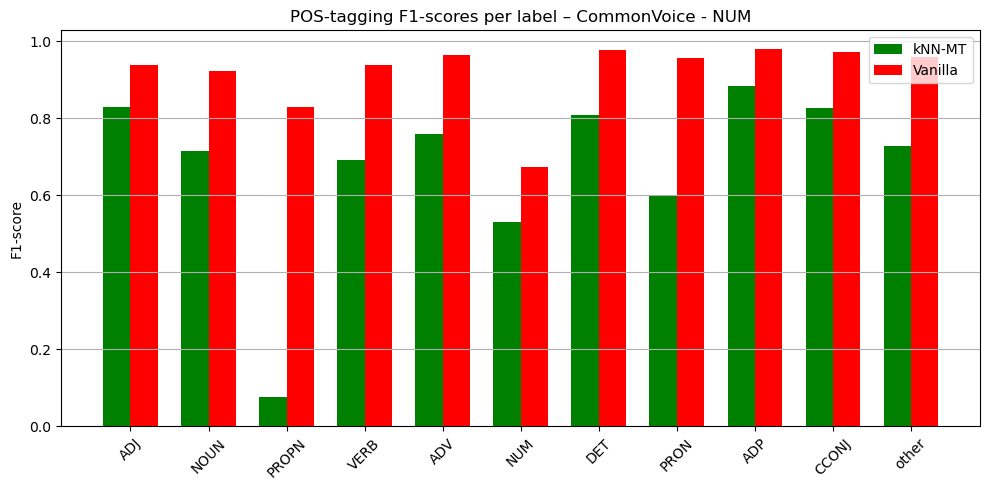

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

labels = df_commonvoice_pos["Label"]
x = range(len(labels))
width = 0.35

ax.bar(x, df_commonvoice_pos["kNN-MT (sys1)"], width, label="kNN-MT", color="green")
ax.bar([i + width for i in x], df_commonvoice_pos["Vanilla (sys2)"], width, label="Vanilla", color="red")

ax.set_ylabel("F1-score")
ax.set_title("POS-tagging F1-scores per label – CommonVoice - NUM")
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis="y")
plt.tight_layout()
plt.show()

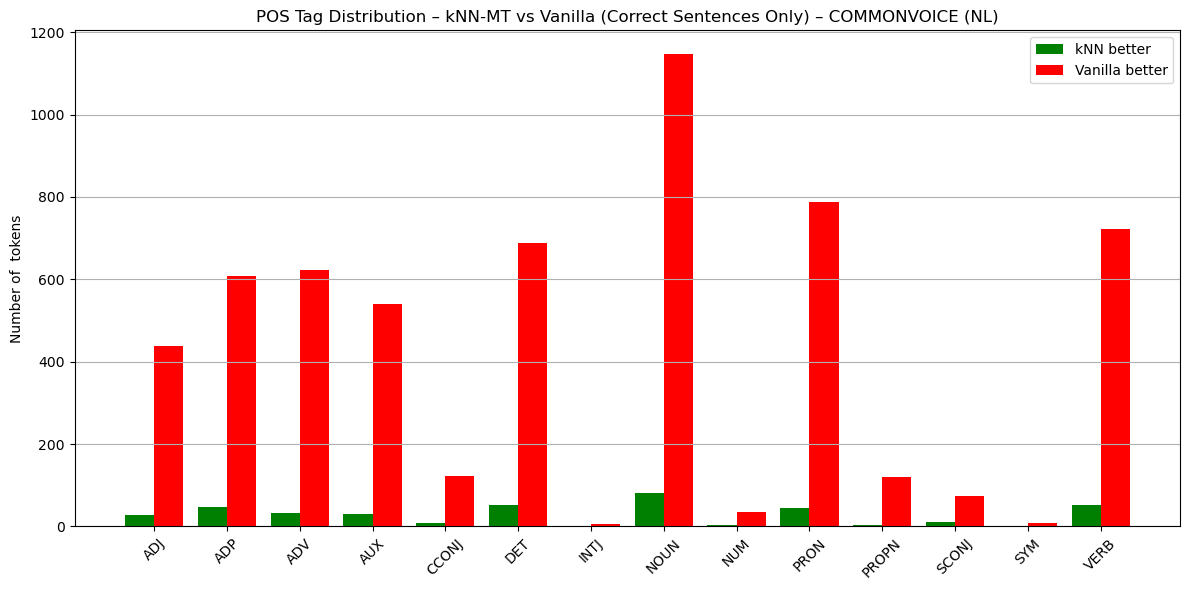

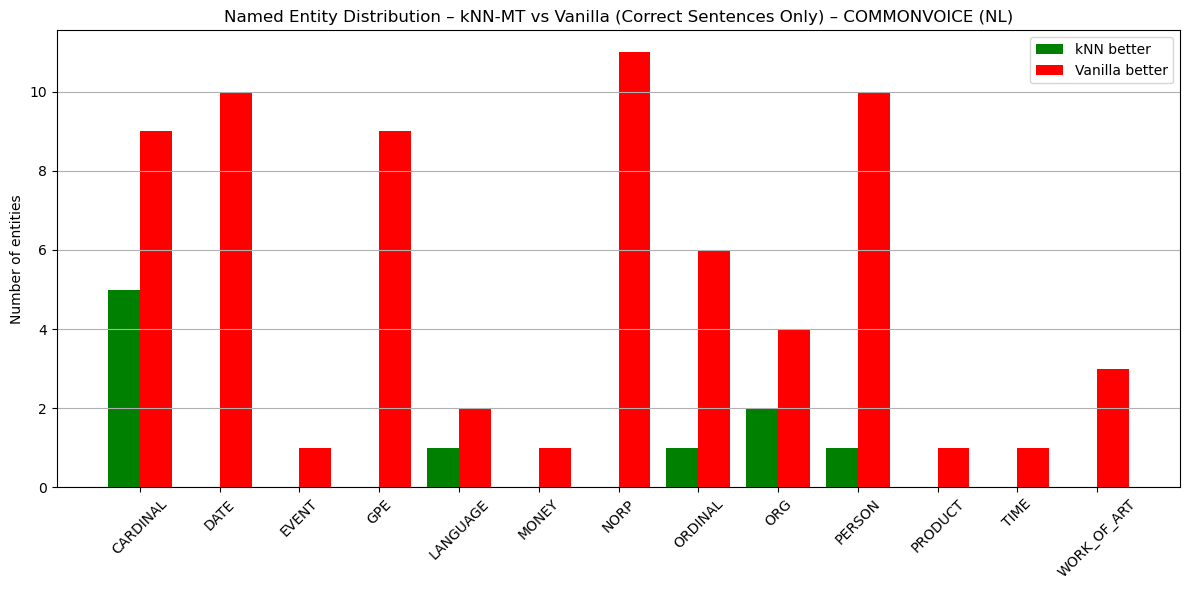

In [8]:
base_path = "/Users/sedatgunay/Desktop/ASR_KNN/dataset data (+outputs)/commonvoice"
lang = "nl"  

# Load data
ref = load_pickle(os.path.join(base_path, "test_ref_texts.pkl"))
knn = load_pickle(os.path.join(base_path, "test_knn_0.1_normalized_texts.pkl"))
van = load_pickle(os.path.join(base_path, "test_van_texts.pkl"))

# Sort better by sentences on systems 
better_knn, better_van = classify_sentences(ref, knn, van)

# POS-tag analysis
pos_knn = extract_pos(better_knn, lang=lang)
pos_van = extract_pos(better_van, lang=lang)
all_pos = sorted(set(pos_knn.keys()).union(pos_van.keys()))

plot_distribution(
    all_pos,
    [pos_knn.get(p, 0) for p in all_pos],
    [pos_van.get(p, 0) for p in all_pos],
    title=f"POS Tag Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – COMMONVOICE ({lang.upper()})",
    ylabel="Number of  tokens"
)

# Entity-analyse
ent_knn = extract_entities(better_knn, lang=lang)
ent_van = extract_entities(better_van, lang=lang)
all_ents = sorted(set(ent_knn.keys()).union(ent_van.keys()))

plot_distribution(
    all_ents,
    [ent_knn.get(e, 0) for e in all_ents],
    [ent_van.get(e, 0) for e in all_ents],
    title=f"Named Entity Distribution – kNN-MT vs Vanilla (Correct Sentences Only) – COMMONVOICE ({lang.upper()})",
    ylabel="Number of entities"
)

In [9]:
# wer analyses
wer_knn = calculate_wer_per_sentence(ref,knn)
wer_van = calculate_wer_per_sentence(ref,van)

# print means 
print("Mean WER (kNN):", wer_summary(ref,knn)["wer"])
print("Mean WER (van):", wer_summary(ref,van)["wer"])


# Vind zinnen waar kNN significant beter was
gain_outliers = get_knn_gain_outliers(ref, knn, van, threshold=0.5)
gain_indices = [entry[0] for entry in gain_outliers]

# gain_outliers

Mean WER (kNN): 0.2753954936517328
Mean WER (van): 0.058506872035616254


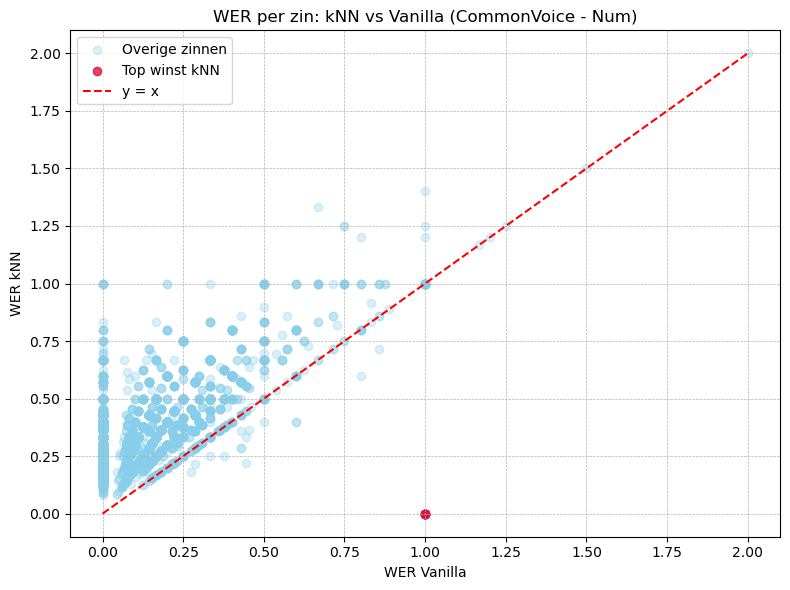

In [10]:
plot_knn_gain_scatter(wer_knn, wer_van,
    gain_indices,
    domain_label="CommonVoice - Num"
)

In [11]:
import pandas as pd

df_gain = pd.DataFrame(gain_outliers, columns=[
    "Index", "ref", "vanilla", "knn", "wer_vanilla", "wer_knn", "wer_gain_knn"
])

# Sorteer op grootste winst, optioneel
df_gain = df_gain.sort_values(by="wer_gain_knn", ascending=False).reset_index(drop=True)

# Bekijk de eerste rijen
display(df_gain)  


,Index,ref,vanilla,knn,wer_vanilla,wer_knn,wer_gain_knn
0,4285,drie,Drie.,drie,1.0,0.0,1.0
1,4286,nee,Nee.,nee,1.0,0.0,1.0
2,4308,vier,Vier.,vier,1.0,0.0,1.0
3,4352,ja,Ja?,ja,1.0,0.0,1.0
4,4364,twee,2,twee,1.0,0.0,1.0
